<a href="https://colab.research.google.com/github/AnIsAsPe/ElementosEstadisticaMachineLearningPython/blob/master/Teorema_del_limite_central_en_letras_de_libro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Importar liberías y archivos

In [17]:
import numpy as np
import pandas as pd

import random
import operator
import re # módulo operaciones expresiones regulares
import unicodedata  #para quitar tildes
from collections import Counter
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#from google.colab import files  #para importar archivos a cloab
#files.upload()

## Definición de funciones

In [3]:
def leer_libro(archivo_txt):
  '''funcion para leer un archivo en formato txt'''
  with open(archivo_txt, "r", encoding="utf8") as f:
    texto = f.read()
    texto = texto.replace("\n", "").replace("\r", "") 
  return texto

In [4]:
def borrar_elementos(texto, lista):
  '''Función para eliminar en un texto los elementos contenidos en una lista, 
  por ejemplo:   autor, titulo y otros elementos'''
  
  for elemento in lista:
    texto = texto.replace(elemento, "")
  return texto

In [5]:

def limpiar_texto(texto):
  '''Función para convertir a minúsculas, quitar signos de puntuación,
  números y tildes'''

  #Convertir en mínusculas 
  texto_limpio = texto.lower()

  #Quitar puntuación
  puntuacion = [".", "," , "-", "\n", ":", ";",'"', "'", "  ",
                "!", "¡", "¿", "?", "(", ")", "<", "«", "»", "~",]
  for p in puntuacion:
    texto_limpio = texto_limpio.replace(p,"")

  #Quitar numeros

  texto_limpio = "".join(filter(lambda x: not x.isdigit(), texto_limpio))

  #Quitar tildes 
  
  texto_limpio =''.join((c for c in unicodedata.normalize('NFD',texto_limpio) if
                         unicodedata.category(c) != 'Mn'))

  return texto_limpio

In [6]:

def genera_texto_nletras(texto, n=1, tot_letras = 100):
  '''Devuelve un texto, utilizando ngramas a partir de letras
  n es la cantidad de letras que se toman en consideración para 
  generar la siguiente'''
  ngramas = {}
  for i in range(len(texto) - n):
    seq = texto[i:i+n]
    if seq not in ngramas.keys():
      ngramas[seq] = []
    ngramas[seq].append(texto[i+n]) 
    
  ngrama = np.random.choice(list(ngramas.keys()))
  nuevo_texto = ngrama
  
  for i in range(tot_letras):
    if ngrama not in ngramas.keys():
      break
    siguiente_letra = np.random.choice(ngramas[ngrama])
    nuevo_texto += siguiente_letra
    ngrama = nuevo_texto[len(nuevo_texto)-n:len(nuevo_texto)]
  return nuevo_texto

In [7]:
def genera_muestras_de_texto(texto, grado=0, 
                             num_muestras=100, 
                             tam_muestra=200 ):
  muestras={}
  for i in range(num_muestras):
    if grado == 0:
      muestras[i]= "".join(random.sample(texto, tam_muestra))
    else:
      muestras[i] = genera_texto_nletras(texto, grado, tam_muestra)
  return pd.Series(muestras, name= 'muestra' )

In [8]:
def cuenta_vocales(texto):
  vocales ='aeiou'
  tot_vocales= 0
  for caracter in texto:
    if caracter in vocales:
      tot_vocales += 1
  return tot_vocales

In [9]:
def cuenta_caracteres_antes_de_n(texto):
  caracteres_antes = 0
  for caracter in texto:
    if caracter == 'n':
      break
    caracteres_antes += 1

  return caracteres_antes

# Distribución gaussiana

## Obtener muestras

a partir de la [distribución de la altura de trabajadores industriales de sexo masculino en Guadalajara](https://www.researchgate.net/publication/31722433_Dimensiones_antropometricas_de_la_poblacion_latinoamericana_Mexico_Cuba_Colombia_Chile_R_Avila_Chaurand_LR_Prado_Leon_EL_Gonzalez_Munoz)

In [32]:
mu, sigma = 1675, 62.8 #milimetros

n = 100 # tamaño de la muestra
m = 500 # número de muestras
alturas_hombres=pd.DataFrame()
for i in range(1, m+1):
  alturas_hombres['muestra '+str(i)]= np.random.normal(mu, sigma, n)
alturas_hombres

,muestra 1,muestra 2,muestra 3,muestra 4,muestra 5,muestra 6,muestra 7,muestra 8,muestra 9,muestra 10,muestra 11,muestra 12,muestra 13,muestra 14,muestra 15,muestra 16,muestra 17,muestra 18,muestra 19,muestra 20,muestra 21,muestra 22,muestra 23,muestra 24,muestra 25,muestra 26,muestra 27,muestra 28,muestra 29,muestra 30,muestra 31,muestra 32,muestra 33,muestra 34,muestra 35,muestra 36,muestra 37,muestra 38,muestra 39,muestra 40,...,muestra 461,muestra 462,muestra 463,muestra 464,muestra 465,muestra 466,muestra 467,muestra 468,muestra 469,muestra 470,muestra 471,muestra 472,muestra 473,muestra 474,muestra 475,muestra 476,muestra 477,muestra 478,muestra 479,muestra 480,muestra 481,muestra 482,muestra 483,muestra 484,muestra 485,muestra 486,muestra 487,muestra 488,muestra 489,muestra 490,muestra 491,muestra 492,muestra 493,muestra 494,muestra 495,muestra 496,muestra 497,muestra 498,muestra 499,muestra 500
0,1681.783107,1766.152266,1702.931665,1615.722851,1633.735563,1653.296691,1652.059351,1652.268193,1678.008516,1662.872033,1663.655698,1667.299890,1765.702209,1722.224057,1728.696730,1692.497072,1693.900058,1734.468270,1661.409272,1669.874208,1746.225021,1656.696977,1646.904912,1737.241770,1671.911939,1615.023268,1694.180298,1651.160900,1692.117918,1674.871890,1673.929401,1717.076272,1760.886544,1588.119058,1736.241922,1619.452140,1633.879653,1803.206947,1750.623507,1696.317481,...,1562.061752,1762.002819,1698.182951,1652.643870,1696.363866,1676.873446,1612.472973,1719.374877,1620.141260,1692.149470,1700.059362,1649.688247,1635.596993,1565.458513,1616.761401,1699.039626,1597.479625,1682.720504,1700.172286,1622.472278,1651.586953,1674.691892,1635.629748,1697.603504,1611.981953,1686.540540,1698.163547,1737.932596,1639.177239,1623.505504,1741.688611,1551.165550,1694.657883,1652.154139,1758.448285,1684.326644,1665.922089,1708.289544,1715.291561,1734.463303
1,1651.216744,1651.537105,1671.793063,1594.074785,1662.509686,1796.665429,1701.456734,1709.222460,1607.872097,1714.796244,1629.382351,1527.669501,1718.422510,1693.924931,1689.739283,1793.441667,1798.517506,1713.352397,1717.030635,1675.206304,1780.664079,1759.041099,1708.684732,1775.367886,1561.865174,1722.127897,1659.310215,1645.367989,1769.190299,1735.901395,1650.736817,1731.983912,1668.118084,1628.946583,1758.524360,1586.282323,1663.124512,1653.985827,1594.661827,1702.149484,...,1658.801548,1807.201974,1725.838435,1706.729364,1630.310904,1628.535284,1699.429367,1586.094988,1664.278902,1673.620490,1598.647777,1718.736419,1557.677711,1706.111061,1640.770308,1703.505268,1642.084923,1642.473049,1595.364410,1691.721006,1667.532256,1743.677056,1704.514796,1674.325951,1652.244017,1700.950193,1711.653955,1655.715145,1727.695658,1675.315284,1722.879890,1732.002982,1617.899741,1667.336442,1715.100942,1621.230312,1773.486893,1789.966443,1624.884227,1704.380719
2,1718.659230,1616.222099,1720.431089,1641.782160,1696.372127,1632.485539,1589.197005,1719.548864,1642.479863,1754.011600,1661.109835,1607.518592,1659.527233,1608.601208,1667.627307,1570.970877,1751.797401,1557.843012,1789.281179,1539.018514,1704.601462,1720.353471,1729.100574,1707.987272,1771.102045,1699.702638,1586.457284,1749.827423,1716.470586,1685.363913,1759.198571,1691.112784,1728.699616,1648.190565,1673.005685,1711.588496,1757.074441,1633.307298,1484.349887,1625.706265,...,1661.778308,1588.186610,1579.516460,1719.659364,1691.510108,1792.788912,1593.522385,1698.283969,1630.753472,1684.319389,1660.438269,1651.632921,1630.075533,1759.137906,1696.457908,1632.111951,1627.970732,1585.173585,1590.843702,1762.476101,1714.713260,1665.629564,1621.600399,1647.900825,1688.129639,1705.936313,1772.268554,1696.666677,1742.108126,1741.114772,1612.674731,1671.350351,1654.611022,1704.603329,1671.460548,1724.886756,1679.720788,1563.705693,1686.991728,1626.301823
3,1803.480816,1657.208201,1696.336846,1620.358374,1712.191210,1682.731874,1728.963278,1652.793678,1706.680500,1531.574271,1643.239695,1774.861107,1553.289954,1637.332997,1705.622519,1724

## Distribución de cada muestra

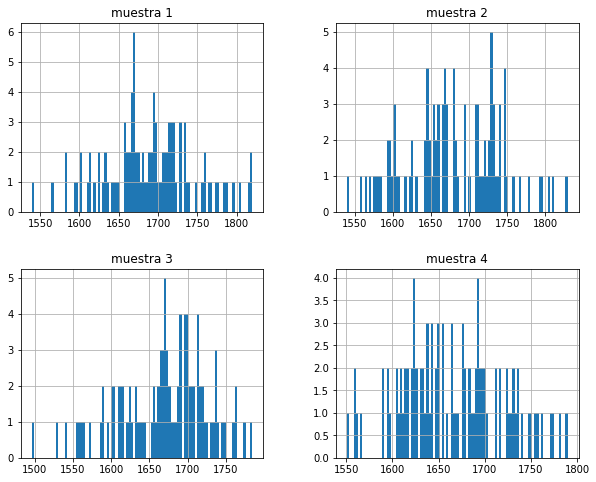

In [33]:
alturas_hombres.iloc[:,0:4].hist(figsize = (10,8), bins=100)
plt.show()

## Distribución de los promedios

In [34]:
medias=alturas_hombres.mean()
medias.sum()/m

1675.1993171062545

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


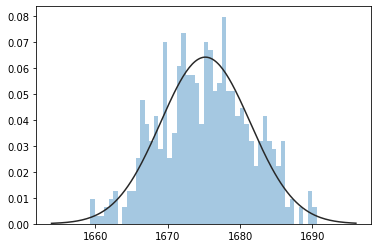

1675.1993171062545


In [35]:

sns.distplot(medias, fit=norm, kde=False, bins=50)
plt.show()
print(medias.sum()/m)

# Distribución Bernoulli

#### Preprocesar libro y obtener probabilidades de los caracteres 

In [18]:
#Leer libro
libro = leer_libro('gabriel_garcia_marquez_cien_annos_soledad.txt')
borrar = ['Gabriel García Márquez', 
          'Cien años de soledad',
          'EDITADO POR "EDICIONES LA CUEVA"',
          'Para J omi García Ascot y María Luisa Elio']

libro =  borrar_elementos(libro, borrar) 
libro_limpio = limpiar_texto(libro)

In [19]:
#Cargar csv con distribución de probabilidad de letras
Ley_P_letras = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/ElementosEstadisticaMachineLearningPython/master/Semana4/Ley_Probabilidad_caracteres_100a%C3%B1os.csv')

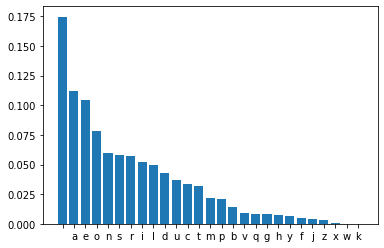

In [20]:
Ley_P_letras=Ley_P_letras.sort_values('probabilidad', ascending=False)
plt.bar(Ley_P_letras['caracter'], Ley_P_letras['probabilidad'] )
plt.show()

2.  Distribución de caracteres por tipo

In [21]:
caracteres = sorted(list(Ley_P_letras['caracter']))
vocales = list('aeiou')
espacio = [' ']

consonantes = []
for c in caracteres:
  if c not in (vocales + espacio):
    consonantes += c 

In [22]:
Ley_P_letras['tipo']=np.nan
Ley_P_letras['tipo']=np.where(Ley_P_letras['caracter'].isin(vocales), 'vocal',
                              np.where(Ley_P_letras['caracter']==' ', 'espacio', 
                                       'consonante'))


In [23]:
por_tipo=Ley_P_letras.groupby('tipo')
Ley_P_tipo_letra = por_tipo.agg({'probabilidad':'sum'})
Ley_P_tipo_letra=Ley_P_tipo_letra.reset_index()
Ley_P_tipo_letra

,tipo,probabilidad
0,consonante,0.441228
1,espacio,0.174719
2,vocal,0.384053


<BarContainer object of 2 artists>

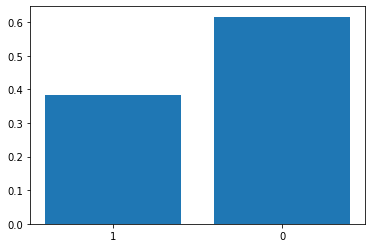

In [24]:
# Distribución bernoulli

p = Ley_P_tipo_letra.loc[2,'probabilidad']
plt.bar(['1','0'],[p, 1-p])

In [25]:
W = [0, 1]
P = [1-p, p]
esperanza = 0
varianza = 0
for elemento, probabilidad in zip(W, P):
  esperanza += elemento * probabilidad
  varianza += ((elemento-esperanza)**2)*probabilidad
print('la esperanza matemática de obtener una vocal es:', esperanza)
print('la varianza matemática de obtener una vocal es:', varianza)

la esperanza matemática de obtener una vocal es: 0.3840527256252816
la varianza matemática de obtener una vocal es: 0.14570616483696736


In [26]:
print(p, 1-p)

0.3840527256252816 0.6159472743747184


### Obtener muestras

In [27]:
%%time
n = 200 # tamaño de la muestra
m = 100000 # número de muestras

muestras=pd.DataFrame()
muestras['texto'] = (genera_muestras_de_texto(libro_limpio, grado = 0,
                                              num_muestras = m, tam_muestra=n))


CPU times: user 13.8 s, sys: 99 ms, total: 13.9 s
Wall time: 13.9 s


In [28]:
indice=pd.Series(['muestra_'+str(i) for i in range (1, m+1)])
muestras.index=indice
muestras['vocales'] = muestras['texto'].apply(cuenta_vocales)
muestras['no_vocales'] = n - muestras['vocales']
muestras['% vocales'] =muestras['vocales']/n
muestras['% no_vocales'] =muestras['no_vocales']/n

In [29]:
muestras.head()

,texto,vocales,no_vocales,% vocales,% no_vocales
muestra_1,iselee iruiaaodqdas eedsb a r o ilatdlanore...,78,122,0.390,0.610
muestra_2,rucor detanbon fat uu ed reoq s a epoaa ore...,77,123,0.385,0.615
muestra_3,nnlslonouinreienus useyndaadea o v aaouaajavoi...,86,114,0.430,0.570
muestra_4,ee bad mlrapenslis biolzgussyo milsnipa e o...,73,127,0.365,0.635
muestra_5,a tbnn a nnucsgcalbsdi aad peturar ver auenm...,82,118,0.410,0.590


### Distribución de cada muestra

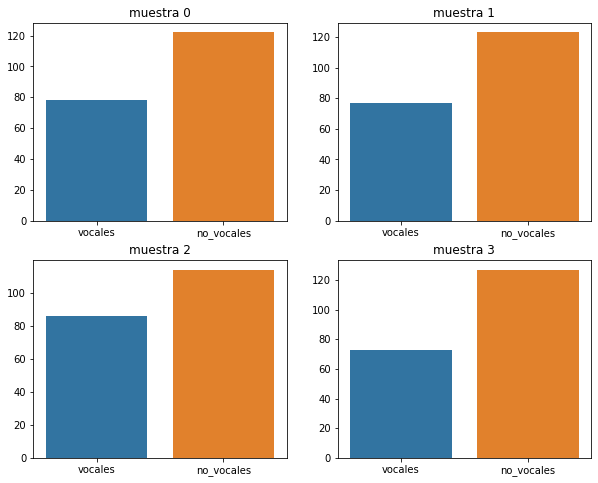

In [30]:
fig, ax = plt.subplots (2, 2, figsize= (10, 8))

for i, subplot in zip(range(4), ax.flatten()):
  x = ['vocales','no_vocales']
  y = [muestras.iloc[i]['vocales'],muestras.iloc[i]['no_vocales'] ]
  titulo='muestra '+str(i)
  sns.barplot(x=x,y=y, ax=subplot).set(title=titulo)
plt.show()

### Distribución de los promedios

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


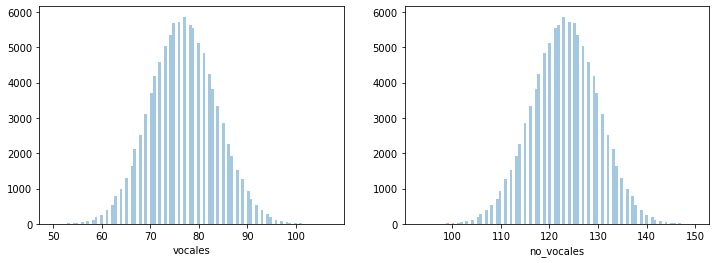

% vocales       0.384082
% no_vocales    0.615918
dtype: float64


In [31]:
m_=m
fig, ax = plt.subplots (1, 2, figsize= (12, 4))
variables=(-4,-3)

for var, subplot in zip(variables, ax.flatten()):
  sns.distplot(muestras.iloc[:m_, var],  kde=False, bins=100, ax=subplot)
plt.show()
print(muestras.iloc[:m_,-2:].mean())


# Distribución exponencial

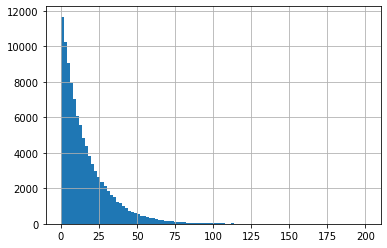

In [36]:
X = pd.Series(muestras['texto'].apply(cuenta_caracteres_antes_de_n))
X.hist(figsize=(6,4),bins=100)
plt.show()

In [37]:
X.mean()

15.82652

**Ejemplos de fenómenos con distribución exponencial:**
- Valores máximos de precipitación diaria
- Compras efectuadas por visitantes en página web
- Tiempo para que se produzca un fallo


¿Qué otros??

### Obtener muestras

In [38]:
n = 10000 # tamaño de la muestra
m = 500 # número de muestras
muestras_exp=pd.DataFrame()
for i in range(1, m+1):
  muestras_exp['muestra '+str(i)]=X.sample(n).reset_index(drop=True)
muestras_exp


,muestra 1,muestra 2,muestra 3,muestra 4,muestra 5,muestra 6,muestra 7,muestra 8,muestra 9,muestra 10,muestra 11,muestra 12,muestra 13,muestra 14,muestra 15,muestra 16,muestra 17,muestra 18,muestra 19,muestra 20,muestra 21,muestra 22,muestra 23,muestra 24,muestra 25,muestra 26,muestra 27,muestra 28,muestra 29,muestra 30,muestra 31,muestra 32,muestra 33,muestra 34,muestra 35,muestra 36,muestra 37,muestra 38,muestra 39,muestra 40,...,muestra 461,muestra 462,muestra 463,muestra 464,muestra 465,muestra 466,muestra 467,muestra 468,muestra 469,muestra 470,muestra 471,muestra 472,muestra 473,muestra 474,muestra 475,muestra 476,muestra 477,muestra 478,muestra 479,muestra 480,muestra 481,muestra 482,muestra 483,muestra 484,muestra 485,muestra 486,muestra 487,muestra 488,muestra 489,muestra 490,muestra 491,muestra 492,muestra 493,muestra 494,muestra 495,muestra 496,muestra 497,muestra 498,muestra 499,muestra 500
0,19,7,38,5,19,7,6,10,4,14,19,1,24,5,18,6,0,2,3,15,1,6,4,46,46,26,16,9,10,6,0,18,7,31,15,6,2,17,23,13,...,3,5,12,15,13,96,4,3,91,0,0,42,27,4,12,1,16,2,4,2,26,1,7,46,0,0,44,3,23,2,3,0,4,34,2,7,71,41,19,14
1,9,2,2,51,26,10,11,16,29,56,4,3,10,26,13,16,21,2,70,15,43,46,10,12,3,2,6,20,86,31,42,10,2,37,57,5,5,3,17,0,...,4,2,5,13,0,17,10,70,17,21,15,45,0,16,16,4,2,2,19,26,12,22,2,5,3,15,8,47,5,47,40,3,9,14,35,15,0,0,5,1
2,0,20,9,10,6,2,5,53,13,32,11,7,10,0,16,21,34,21,67,27,8,21,5,50,2,8,7,7,16,20,3,20,18,1,24,4,3,0,11,3,...,25,10,85,31,18,16,5,5,3,3,9,20,13,17,2,39,3,14,13,48,24,9,8,16,1,10,13,37,31,4,8,14,38,0,3,11,5,30,47,9
3,17,0,30,18,9,54,36,42,14,8,55,22,2,32,67,4,23,6,15,37,14,64,32,15,50,7,10,17,31,5,22,9,9,1,22,11,11,9,8,38,...,18,43,19,3,4,11,15,4,7,18,8,80,6,0,9,7,0,13,39,15,3,4,15,2,27,3,17,15,6,5,2,170,19,62,30,52,16,10,21,63
4,12,6,56,1,14,11,15,31,25,21,3,11,5,5,12,23,0,18,13,20,8,5,19,8,14,1,4,16,1,32,6,23,41,8,37,5,9,6,2,13,...,35,0,6,4,83,15,0,70,44,23,13,1,17,4,36,1,43,1,33,2,95,5,3,27,17,11,2,7,30,24,3,1,27,2,24,24,27,16,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,41,0,3,6,8,16,2,0,24,11,61,3,3,6,2,33,19,70,14,10,15,35,5,3,4,3,8,40,7,46,6,13,1,9,5,12,10,11,15,30,...,7,21,1,27,28,0,63,29,5,20,34,51,42,7,4,0,15,8,7,9,5,21,31,37,3,2,70,0,9,7,15,8,5,0,10,5,13,16,11,3
9996,22,18,1,16,17,26,4,14,43,11,1,12,0,5,9,30,3,13,10,14,31,0,49,51,0,3,4,18,4,15,19,19,46,13,36,13,13,8,5,2,...,6,0,24,26,6,0,15,22,7,4,12,6,41,3,1,18,22,13,12,0,5,10,18,19,22,22,3,6,3,4,28,1,16,49,5,13,0,3,8,2
9997,11,13,21,7,16,25,7,27,1,36,1,5,6,22,13,23,107,9,5,5,4,8,6,1,5,11,4,4,22,13,7,2,10,19,11,58,7,18,3,4,...,16,3,32,7,32,17,4,2,56,31,3,10,5,22,0,1,37,3,47,15,9,10,44,38,7,32,4,2,1,19,15,48,0,0,1,31,1,3,36,18
9998,15,24,33,6,45,4,28,15,1,9,36,18,9,7,37,1,34,12,21,0,28,0,1,6,31,9,6,7,8,3,21,5,7,15,38,0,17,35,24,6,...,2,41,5,40,8,22,9,0,88,1,7,4,10,12,14,9,29,8,25,12,16,51,0,5,6,17,6,7,0,20,18,23,6,3,0,2,27,15,11,35


### Distribución de cada muestra

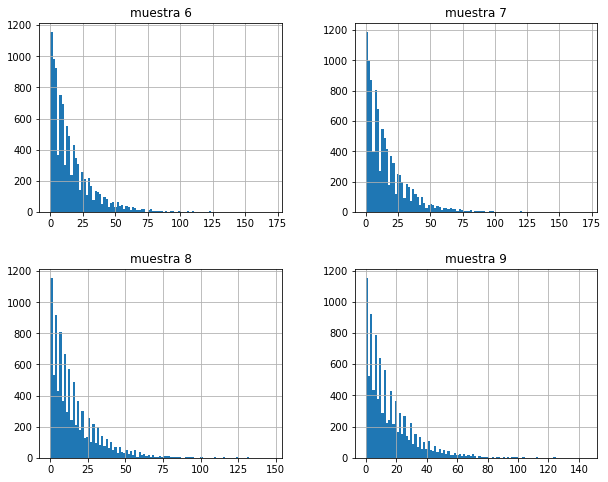

In [39]:
muestras_exp.iloc[:,5:9].hist(figsize = (10,8), bins=100)
plt.show()

### Distribución de los promedios

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


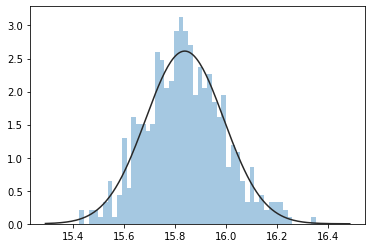

In [40]:
from scipy.stats import norm
sns.distplot(muestras_exp.mean(), fit=norm, kde=False, bins=50)



https://seeing-theory.brown.edu/probability-distributions/index.html

